In [251]:
import json
import uproot
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
from coffea import nanoevents
from coffea import processor
import time

import argparse
import warnings
import pyarrow as pa
import pyarrow.parquet as pq
import pickle as pkl
import pandas as pd
import os
import sys
sys.path.append("../")

from collections import defaultdict
import pickle as pkl
import pyarrow as pa
import awkward as ak
import numpy as np
import pandas as pd
import json
import os
import shutil
import pathlib
from typing import List, Optional
import pyarrow.parquet as pq

from coffea import processor
from coffea.nanoevents.methods import candidate, vector
from coffea.analysis_tools import Weights, PackedSelection

import warnings
warnings.filterwarnings("ignore", message="Found duplicate branch ")
warnings.filterwarnings("ignore", category=DeprecationWarning)
np.seterr(invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [252]:
! ls ../rootfiles

HWW       dy2.root  hww1.root hww3.root qcd2.root
dy1.root  dy3.root  hww2.root qcd1.root qcd3.root


In [253]:
# load a root file into coffea-friendly NanoAOD structure
import uproot
f = uproot.open(f"../rootfiles/hww1.root")
num = f['Events'].num_entries   ### checks number of events per file 
print(f'number of events per file is {num}')

events = nanoevents.NanoEventsFactory.from_root(f, "Events").events()

number of events per file is 98400


In [254]:
def pad_val(
    arr: ak.Array,
    value: float,
    target: int = None,
    axis: int = 0,
    to_numpy: bool = False,
    clip: bool = True,
):
    """
    basically: preserves the nested structure of the ak array and replaces None values with -1
    pads awkward array up to ``target`` index along axis ``axis`` with value ``value``,
    optionally converts to numpy array
    """
    if target:
        ret = ak.fill_none(ak.pad_none(arr, target, axis=axis, clip=clip), value, axis=None)
    else:
        ret = ak.fill_none(arr, value, axis=None)
    return ret.to_numpy() if to_numpy else ret

In [255]:
def build_p4(cand):
    return ak.zip(
        {
            "pt": cand.pt,
            "eta": cand.eta,
            "phi": cand.phi,
            "mass": cand.mass,
#             "charge": cand.charge,
        },
        with_name="PtEtaPhiMCandidate",
        behavior=candidate.behavior,
    )

In [354]:
nevents = len(events)

# define muon objects
loose_muons = (
    (((events.Muon.pt > 30) & (events.Muon.pfRelIso04_all < 0.25)) |
     (events.Muon.pt > 55))
    & (np.abs(events.Muon.eta) < 2.4)
    & (events.Muon.looseId)
)
n_loose_muons = ak.sum(loose_muons, axis=1)

good_muons = (
    (events.Muon.pt > 28)
    & (np.abs(events.Muon.eta) < 2.4)
    & (np.abs(events.Muon.dz) < 0.1)
    & (np.abs(events.Muon.dxy) < 0.05)
    & (events.Muon.sip3d <= 4.0)
    & events.Muon.mediumId
)
n_good_muons = ak.sum(good_muons, axis=1)

# define electron objects
loose_electrons = (
    (((events.Electron.pt > 38) & (events.Electron.pfRelIso03_all < 0.25)) |
     (events.Electron.pt > 120))
    & ((np.abs(events.Electron.eta) < 1.44) | (np.abs(events.Electron.eta) > 1.57))
    & (events.Electron.cutBased >= events.Electron.LOOSE)
)
n_loose_electrons = ak.sum(loose_electrons, axis=1)

good_electrons = (
    (events.Electron.pt > 38)
    & ((np.abs(events.Electron.eta) < 1.44) | (np.abs(events.Electron.eta) > 1.57))
    & (np.abs(events.Electron.dz) < 0.1)
    & (np.abs(events.Electron.dxy) < 0.05)
    & (events.Electron.sip3d <= 4.0)
    & (events.Electron.mvaFall17V2noIso_WP90)
)
n_good_electrons = ak.sum(good_electrons, axis=1)

# leading lepton
goodleptons = ak.concatenate([events.Muon[good_muons], events.Electron[good_electrons]], axis=1)
goodleptons = goodleptons[ak.argsort(goodleptons.pt, ascending=False)]
candidatelep = ak.firsts(goodleptons)

In [355]:
# candidate leptons
candidatelep_p4 = build_p4(candidatelep)

# MET
met = events.MET
mt_lep_met = np.sqrt(
    2. * candidatelep_p4.pt * met.pt * (ak.ones_like(met.pt) - np.cos(candidatelep_p4.delta_phi(met)))
)

# JETS
goodjets = events.Jet[
    (events.Jet.pt > 30)
    & (abs(events.Jet.eta) < 2.5)
    & events.Jet.isTight
    & (events.Jet.puId > 0)
]
ht = ak.sum(goodjets.pt, axis=1)

# FATJETS
fatjets = events.FatJet

good_fatjets = (
    (fatjets.pt > 200)
    & (abs(fatjets.eta) < 2.5)
    & fatjets.isTight
)
n_fatjets = ak.sum(good_fatjets, axis=1)

good_fatjets = fatjets[good_fatjets]
good_fatjets = good_fatjets[ak.argsort(good_fatjets.pt, ascending=False)]

candidatefj = ak.firsts(good_fatjets[ak.argmin(good_fatjets.delta_r(candidatelep_p4), axis=1, keepdims=True)])

In [320]:
candidatefj.pt

<Array [None, None, None, ... None, None, None] type='98400 * ?float32[parameter...'>

In [260]:
good_fatjets.delta_phi(met)

<Array [None, None, [], ... None, None, None] type='98400 * option[var * float32]'>

In [374]:
x = candidatefj.mass[~ak.is_none(candidatefj.mass)]
y = (candidatefj-candidatelep_p4).mass[~ak.is_none((candidatefj-candidatelep_p4).mass)]

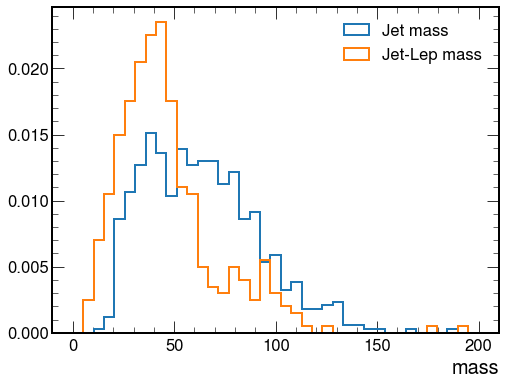

In [376]:
fig, ax = plt.subplots(figsize=(8,6))
bins = np.linspace(0, 200, 40)

for sample in ["HWW"]:
    ax.hist(x, bins, histtype="step", linewidth=2, label = f"Jet mass", density=True)
    ax.hist(y, bins, histtype="step", linewidth=2, label = f"Jet-Lep mass", density=True)
    ax.legend()
    # ax.set_ylim(0, 20000)
    ax.set_xlabel(r"mass")
#     ax.set_yscale("log")

In [433]:
"""
Using the reference https://cds.cern.ch/record/1630709/files/MSc_thesis_Stefan_Richter_with_info_pages.pdf.
Also using:
    px = pt cos(phi)
    py = pt sin(phi)
    pz = pt sinh(eta)
"""

Lep = candidatelep_p4
Jet = candidatefj - Lep

### definitions
m_H = 125

m_Jet = Jet.mass
E_Jet = Jet.energy

m_Lep = Lep.mass
E_Lep = Lep.energy

# momentum vectors for Jet and Lep
px_Jet = Jet.pt * np.cos(Jet.phi)
py_Jet = Jet.pt * np.sin(Jet.phi)
pz_Jet = Jet.pt * np.sinh(Jet.eta)

px_Lep = Lep.pt * np.cos(Lep.phi)
py_Lep = Lep.pt * np.sin(Lep.phi)
pz_Lep = Lep.pt * np.sinh(Lep.eta)

pJet_dot_pLep = px_Jet*px_Lep + py_Jet*py_Lep + pz_Jet*pz_Lep

# met
px_met = met.pt * np.cos(met.phi)
py_met = met.pt * np.sin(met.phi)

# computation:
Last_term = (px_met*(px_Jet+px_Lep) + py_met*(py_Jet+py_Lep))
A = (1/(E_Jet+E_Lep)) * ( 0.5*(m_H**2 - m_Jet**2 - m_Lep**2) - E_Jet*E_Lep + pJet_dot_pLep + Last_term )

B = (pz_Jet**2 + pz_Lep**2) / (E_Jet + E_Lep)

D = A**2 - (px_met**2 + py_met**2)*(1-B**2)

# reconstruct the met pz
pz_met_pos = ( (A*B) + np.sqrt(D) ) / (1-B**2)
pz_met_neg = ( (A*B) - np.sqrt(D) ) / (1-B**2)

In [421]:
pz_met_pos = pz_met_pos[~ak.is_none(pz_met_pos)]
pz_met_neg = pz_met_neg[~ak.is_none(pz_met_neg)]

Text(1, 0, 'MET $p_z$')

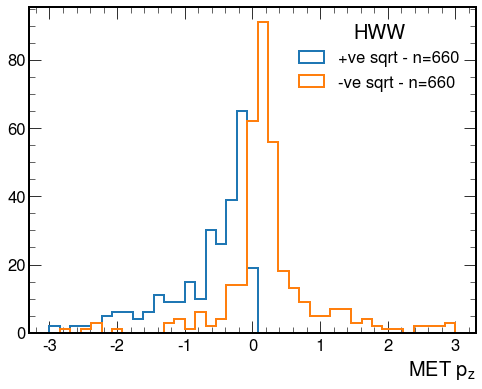

In [395]:
import math
import matplotlib
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(8,6))
bins = np.linspace(-3, 3, 40)
ax.hist(pz_met_pos, bins, histtype="step", linewidth=2, label = f"+ve sqrt - n={len(pz_met_pos)}")
ax.hist(pz_met_neg, bins, histtype="step", linewidth=2, label = f"-ve sqrt - n={len(pz_met_neg)}")
ax.legend(title="HWW")
# ax.set_ylim(0, 20000)
ax.set_xlabel(r"MET $p_z$")

# Reconstruct the higgs

In [443]:
### pick smallest pz because we expect heavy physics to result in central object which has hight pT (artifact of pdf proton) - more probable to have less pT in z axis

met1 = ak.zip(
        {
            "pt": met.pt,
            "eta": np.arcsinh(pz_met/met.pt),
#             "eta": candidatelep_p4.eta,
            "phi": met.phi,
            "mass": 0,
#             "charge": cand.charge,
        },
        with_name="PtEtaPhiMCandidate",
        behavior=candidate.behavior,
    )
# met2 = ak.zip(
#         {
#             "pt": met.pt,
# #             "eta": np.arcsinh(pz_met_neg/met.pt),
#             "eta": candidatelep_p4.eta,
#             "phi": met.phi,
#             "mass": 0,
# #             "charge": cand.charge,
#         },
#         with_name="PtEtaPhiMCandidate",
#         behavior=candidate.behavior,
#     )

ValueError: cannot broadcast records in this type of operation

(https://github.com/scikit-hep/awkward-1.0/blob/1.10.3/src/awkward/_util.py#L1066)

In [444]:
rec_higgs1 = Jet+met1
rec_higgs1 = rec_higgs1[~ak.is_none(rec_higgs1)].mass

# rec_higgs2 = Jet+met2
# rec_higgs2 = rec_higgs2[~ak.is_none(rec_higgs2)].mass

Text(1, 0, 'rec Higgs mass')

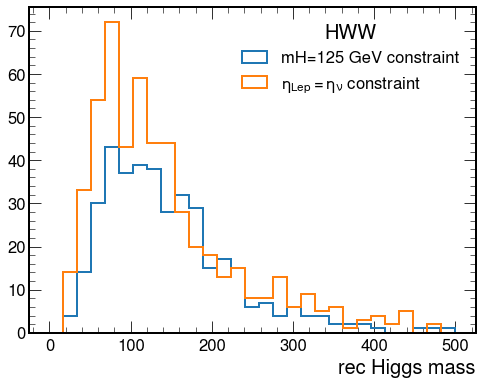

In [445]:
fig, ax = plt.subplots(figsize=(8,6))
bins = np.linspace(0, 500, 30)

ax.hist(rec_higgs1, bins, histtype="step", linewidth=2, label = f"mH=125 GeV constraint")
ax.hist(rec_higgs2, bins, histtype="step", linewidth=2, label = r"$\eta_{Lep}=\eta_{\nu}$ constraint")
ax.legend(title="HWW")
# ax.set_ylim(0, 20000)
ax.set_xlabel(r"rec Higgs mass")

In [280]:
rec_higgs[~ak.is_none(rec_higgs)].mass

<Array [305, 536, 281, ... 320, 837, 1.02e+03] type='547 * ?float64'>

In [ ]:
# ->goal is to see sharp peak near 125

### 1. share the mT histogram (<100 and >100)

### 2. why blue is not sharp peak
### 3. orange is reasonable
### 4. use eta_neut=eta_jet